/opt/conda/envs/JD/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Global seed set to 42
Some weights of the model checkpoint at klue/roberta-small were not used when initializing RobertaForQuestionAnswering: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.bias', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification

new_lr : 0.00013593563908785269


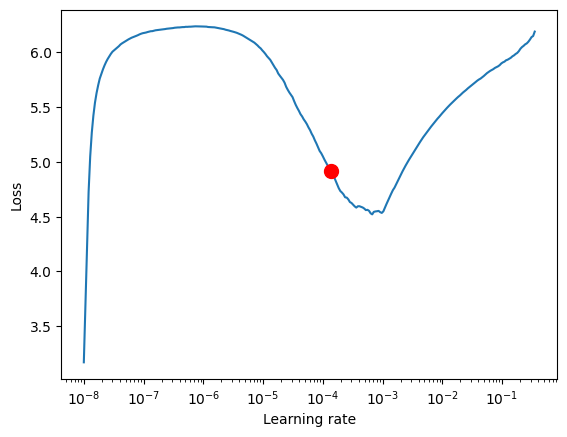

In [1]:
import sys
sys.path.append("/opt/ml/input/code/pl")
import matplotlib.pyplot 
import torch
from omegaconf import OmegaConf
from pytorch_lightning.callbacks import RichProgressBar

from datamodule.base_data import *
from models.base_model import *

cfg = OmegaConf.load("/opt/ml/input/code/pl/config/base_config.yaml")

pl.seed_everything(cfg.train.seed, workers=True)

# dataloader와 model을 생성합니다.
dataloader = Dataloader(
    cfg.model.model_name,
    cfg.train.batch_size,
    cfg.data.shuffle,
    cfg.path.train_path,
    cfg.path.test_path,
    cfg.train.seed,
)
model = Model(cfg)

# gpu가 없으면 'gpus=0'을, gpu가 여러개면 'gpus=4'처럼 사용하실 gpu의 개수를 입력해주세요
trainer = pl.Trainer(
    precision=16,
    accelerator="gpu",
    devices=1,
    max_epochs=cfg.train.max_epoch,
    callbacks=[RichProgressBar()],
    auto_lr_find=True,
    # deterministic=True,
    # limit_train_batches=0.15,  # use only 30% of training data
    # limit_val_batches = 0.01, # use only 1% of val data
    # limit_train_batches=10    # use only 10 batches of training data
)

lr_finder = trainer.tuner.lr_find(model=model,datamodule=dataloader, num_training=300)
lr_finder.results

fig = lr_finder.plot(suggest=True)

new_lr = lr_finder.suggestion()
print('new_lr :',new_lr)

fig.show()